In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from script.text_cleaning import clean_html, remove_links, remove_special_characters, removeStopWords, remove_, remove_digits, lower, email_address, non_ascii, punct, hashtags
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\likah\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df_sms = pd.read_csv("data/final.csv", encoding="ISO-8859-1", index_col=0)
# df_sms = df_sms[['v1','v2']]
# df_sms['spam'] = df_sms['v1'].apply(lambda x: 1 if x=="spam" else 0)
# df_sms.drop("v1", axis = 1, inplace = True)
df_sms.rename(columns={'v2':'text'}, inplace = True)
df_sms.head(5)

,text,spam
0,"Dear Homeowner, Interest Rates are at thei...",1
1,Help wanted. We are a 14 year old fortune 500...,1
2,Subject: ua 4 for meter 8608 - 6 / 98 - deal 9...,0
3,Subject: fw : pymt for 03 / 01 sales adjustmen...,0
4,Sean O'Donnell wrote: > Doesnt answer your qu...,0


In [4]:
df_sms["spam"].value_counts()

1    3000
0    3000
Name: spam, dtype: int64

# BERT (base)

In [5]:
from script.text_cleaning import clean_html, remove_links, remove_special_characters, removeStopWords, remove_, remove_digits, lower, email_address, non_ascii, punct, hashtags
def text_preprocess(data,col):
    data[col] = data[col].apply(func=clean_html)
    data[col] = data[col].apply(func=remove_)
    data[col] = data[col].apply(func=removeStopWords)
    data[col] = data[col].apply(func=remove_special_characters)
    data[col] = data[col].apply(func=punct)
    data[col] = data[col].apply(func=non_ascii)
    data[col] = data[col].apply(func=email_address)
    data[col] = data[col].apply(func=lower)
    return data

In [6]:
df_sms = text_preprocess(df_sms,'text')
df_sms.head()

,text,spam
0,dear homeowner interest rates lowest point 40 ...,1
1,help wanted we 14 year old fortune 500 company...,1
2,subject ua 4 meter 8608 6 98 deal 96731 daren ...,0
3,subject fw pymt 03 01 sales adjustment cowtrap...,0
4,sean o donnell wrote doesnt answer question th...,0


In [7]:
# Tokenization
from transformers import AutoTokenizer
from transformers import TFBertForSequenceClassification, BertConfig

model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
from sklearn.model_selection import train_test_split

# x_train, x_test, y_train, y_test = train_test_split(messages, y, test_size=0.2, random_state=42)
train_df, test_df = train_test_split(df_sms,test_size=0.3,random_state=42,shuffle=True,stratify=df_sms.spam)

In [9]:
max_len = 50

In [10]:
X_train = tokenizer(train_df.text.to_list(),
                   max_length=max_len,
                   padding='max_length',
                   truncation=True,
                   add_special_tokens=True,
                   return_tensors="tf",
                   return_attention_mask=True,
                   return_token_type_ids=True,
                   verbose=True)

X_test = tokenizer(test_df.text.to_list(),
                  max_length=max_len,
                  padding='max_length',
                  truncation=True,
                  add_special_tokens=True,
                  return_tensors="tf",
                  return_attention_mask=True,
                  return_token_type_ids=True,
                  verbose=True)

In [30]:
checkpoint_filepath = 'model/bert_base'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_balanced_accuracy',
    mode='max',
    save_best_only=True)

In [31]:
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import to_categorical, plot_model

metrics = BinaryAccuracy('balanced_accuracy')
loss = BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=5e-5,epsilon=2e-8,decay=0.01,clipnorm=1.0)

model.compile(optimizer=optimizer, loss=loss, metrics=metrics, run_eagerly=True)

# start training model
r = model.fit(x = {'input_ids': X_train['input_ids'], 'attention_mask':X_train['attention_mask'], 'token_type_ids':X_train['token_type_ids']}, y = to_categorical(train_df.spam),
          epochs=5,
          validation_data=({'input_ids': X_test['input_ids'], 'attention_mask':X_test['attention_mask'], 'token_type_ids':X_test['token_type_ids']},to_categorical(test_df.spam)), 
          callbacks= [model_checkpoint_callback])

Epoch 1/5
132/132 [==============================] - ETA: 0s - loss: 0.2987 - balanced_accuracy: 0.8707 

INFO:tensorflow:Assets written to: model\bert_base\assets


INFO:tensorflow:Assets written to: model\bert_base\assets


132/132 [==============================] - 1597s 12s/step - loss: 0.2987 - balanced_accuracy: 0.8707 - val_loss: 0.1331 - val_balanced_accuracy: 0.9536
Epoch 2/5
132/132 [==============================] - ETA: 0s - loss: 0.0802 - balanced_accuracy: 0.9749 

INFO:tensorflow:Assets written to: model\bert_base\assets


INFO:tensorflow:Assets written to: model\bert_base\assets


132/132 [==============================] - 1672s 13s/step - loss: 0.0802 - balanced_accuracy: 0.9749 - val_loss: 0.0999 - val_balanced_accuracy: 0.9703
Epoch 3/5
132/132 [==============================] - 1674s 13s/step - loss: 0.0350 - balanced_accuracy: 0.9910 - val_loss: 0.1006 - val_balanced_accuracy: 0.9681
Epoch 4/5
132/132 [==============================] - 1669s 13s/step - loss: 0.0253 - balanced_accuracy: 0.9945 - val_loss: 0.1039 - val_balanced_accuracy: 0.9683
Epoch 5/5
132/132 [==============================] - 1623s 12s/step - loss: 0.0140 - balanced_accuracy: 0.9974 - val_loss: 0.1214 - val_balanced_accuracy: 0.9658


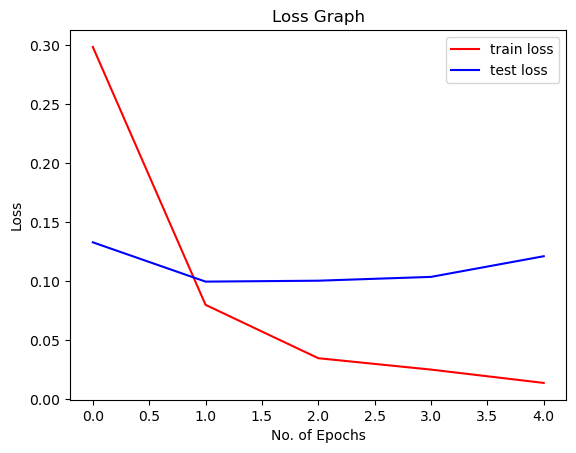

In [32]:
import matplotlib.pyplot as plt

plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

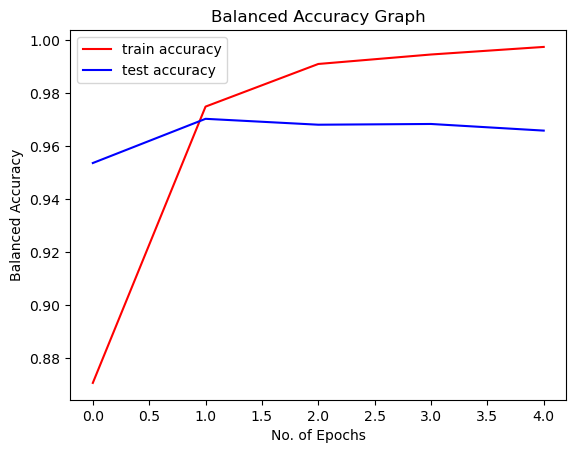

In [33]:
plt.plot(r.history['balanced_accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_balanced_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy Graph')
plt.legend();

### test

In [11]:
model_pred = tf.keras.models.load_model("model/bert_base")

In [18]:
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import to_categorical, plot_model

metrics = BinaryAccuracy('balanced_accuracy')
loss = BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=5e-5,epsilon=2e-8,decay=0.01,clipnorm=1.0)

model_pred.compile(optimizer=optimizer, loss=loss, metrics=metrics, run_eagerly=True)

In [19]:
loss, acc = model_pred.evaluate({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask'], 'token_type_ids': X_test['token_type_ids']},to_categorical(test_df.spam))
print("Test Binary Crossentropy Loss:", loss)
print("Test Binary Accuracy:", acc)

57/57 [==============================] - 158s 3s/step - loss: 0.0999 - balanced_accuracy: 0.9703
Test Binary Crossentropy Loss: 0.09985503554344177
Test Binary Accuracy: 0.9702777862548828


In [ ]:
test_predictions = model_pred.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
test_predictions = np.argmax(test_predictions[0], axis = 1)
print("Confusion Matrix:")
print(confusion_matrix(test_df.spam,test_predictions))
print("Classification Report:")
print(classification_report(test_df.spam,test_predictions, digits = 4))